In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [15]:
# import the state/action space generating function
from state_space_setup import *


# load the necessary data created by the optimisation script
cost_matrix = np.load("cost_matrix.npy")
trans_prob_matrix = np.load('trans_prob_matrix.npy')
policy = pd.read_csv('policy.csv')

# format the State column in the policy dataframe
policy['State'] = policy['State'].apply(lambda x: tuple(map(int, x.strip('()').split(','))))

# display the policy to dataframe to verify that the loading was successful
display(policy)

# extract the maximum number of parts from the policy dataframe
maximum_parts = policy['State'].apply(lambda x: x[0]).max()
print("Maximum number of parts in the inventory:", maximum_parts)

# generate the state space
state_space = get_state_space(maximum_parts)
state_tuples = list(map(tuple, state_space))

,State,Order_size
0,"(0, 0)",21
1,"(0, 1)",20
2,"(0, 2)",19
3,"(0, 3)",18
4,"(0, 4)",17
...,...,...
248,"(19, 1)",0
249,"(19, 2)",0
250,"(20, 0)",0
251,"(20, 1)",0


Maximum number of parts in the inventory: 21


In [38]:
# simulation function
def simulate_period(initial_state, policy_df, num_periods = 1200):
    """
    Input: initial_state (tuple): Initial state of the inventory.
           policy_df (pd.DataFrame): A two-column dataframe representing the chosen policy.
           num_periods (int): The number of weeks for which we want the simulation to run.
    Output: SAC_df (pd.DataFrame): Dataframe containing the states, chosen actions and the
                                   costs associated with (old state, action, new state).

    This function simulates num_periods weeks of inventory states. At each stage the 
    algorithm picks an action according to the provided policy (policy_df), draws a 
    new state according to the probability transition matrix and computes the associated
    cost using the cost matrix - both created in the optimisation script.
    """
    global maximum_parts
    global trans_prob_matrix
    global cost_matrix

    # intialise the list to store the states, actions and costs
    states = [initial_state]
    actions = [policy_df.loc[policy_df["State"] == initial_state, "Order_size"].values[0]]
    costs = [0]

    for _ in range(num_periods):
        # get the current state action
        current_state = states[-1]
        action = actions[-1]

        # sample the new state based on the current state and action
        current_idx = get_index(current_state[0], current_state[1], maximum_parts)
        pmf = trans_prob_matrix[current_idx, :, action]
        new_state = state_tuples[np.random.choice(np.arange(len(state_tuples)), p=pmf)]
        
        # calculate and store the cost of the simulated scenario
        new_idx = get_index(new_state[0], new_state[1], maximum_parts)
        cost = cost_matrix[current_idx, new_idx, action]
        costs.append(cost)

        # store the new state and the corresponding action
        states.append(new_state)
        actions.append(policy_df.loc[policy_df["State"] == new_state, "Order_size"].values[0])

    SAC_df = pd.DataFrame({
        "States" : states,
        "Actions" : actions,
        "Costs" : costs
    })
    
    return SAC_df

In [39]:
def total_cost(simulated_data, plots = True, discount_factor=0.995):
    """
    Input: simulated_data (pd.DataFrame): A three-column dataframe containing the simulated
                                          states, chosen actions and associated costs.
           plots (bool): Variable indicating if plots should be produced
           discount_factor (float): Chosen discount factor weighting the future costs.
    Output: total_cost (float): Total discounted cost of the initial state over the 
                                simulated period.

    This function takes the simulated output in the form of a dataframe. If the plots parameter
    is set to True, the function presents the trend in the inventory level and position as 
    line plots as well as cumulative discounted cost.
    """
    
    # calculate the discounted cumulative cost
    factor_sequence = discount_factor ** np.arange(len(simulated_data["Costs"]))
    cum_discounted_cost = np.cumsum(factor_sequence * np.array(simulated_data["Costs"]))

    if plots:
        # not so disgusting colours for the plots
        col1 = '#1F77B4'
        col2 = '#2CA02C'
        col3 = '#D62728'
        col4 = "#DACE4A"
        
        # prepare the data for plotting
        inventory_levels = [state[0] for state in simulated_data["States"]]
        inventory_positions = [state[0] + state[1] for state in simulated_data["States"]]

        # plot the inventory levels, positions and the cumulative costs
        fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

        # subplot 1: inventory level
        axs[0].plot(np.arange(len(inventory_levels)), inventory_levels, 
                    label='Inventory Level', color=col1, linewidth=0.75)
        axs[0].set_ylabel('Inventory Level')
        axs[0].legend()

        # subplot 2: inventory position
        axs[1].plot(np.arange(len(inventory_positions)), inventory_positions, 
                    label='Inventory Position', color=col2, linewidth=0.75)
        axs[1].set_ylabel('Inventory Position')
        axs[1].legend()

        # subplot 3: cumulative cost
        axs[2].plot(np.arange(len(cum_discounted_cost)), cum_discounted_cost, 
                    label='Cumulative Discounted Value of the Initial State', color=col3,
                    linewidth=0.75)
        axs[2].set_ylabel('Cumulative Cost')
        axs[2].set_xlabel('Week')
        axs[2].legend()

        plt.tight_layout()
        plt.show()
        
    # extract the estimated total discounted cost of the initial state
    total_cost = cum_discounted_cost[-1]
    return total_cost

Initial state: (5, 9)


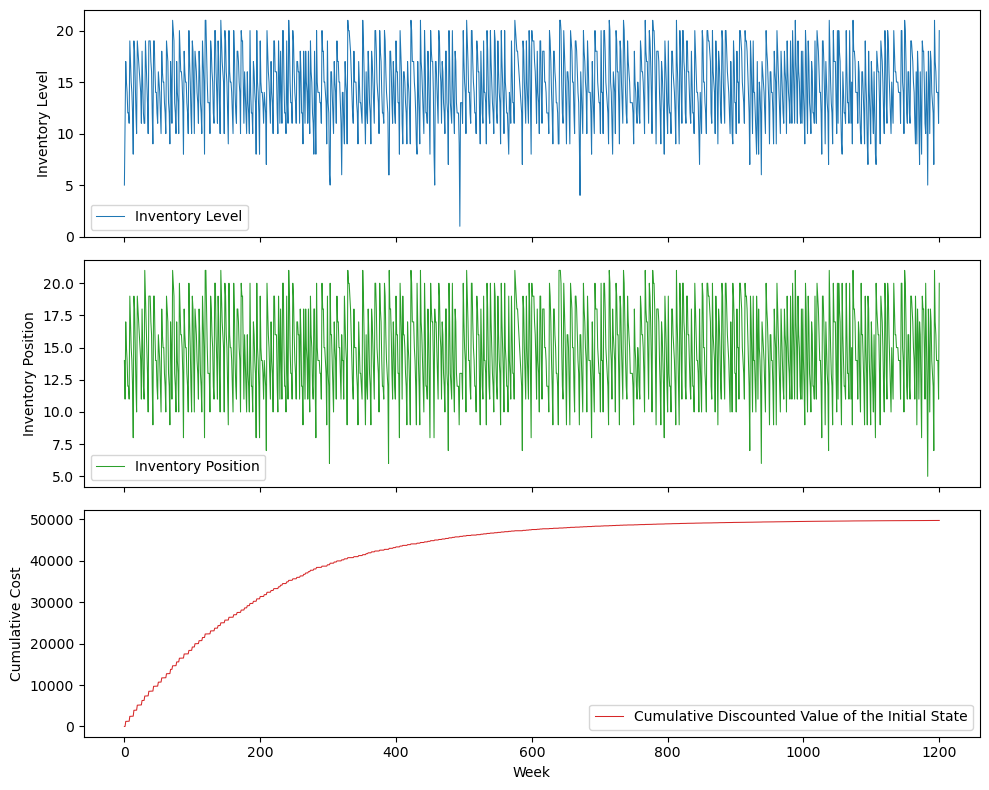

49727.91556967068
2514.514800387471


In [ ]:
# set the seed for reproducibility
np.random.seed(123)

# choose a random initial state from the state space
sampled_state = state_tuples[np.random.randint(len(state_tuples))]
print("Initial state:", sampled_state)

# simulate the period
data1 = simulate_period(sampled_state, policy)
print(total_cost(data1))

data1b = simulate_period(sampled_state, policy())
print(total_cost(data1, plots=False) - total_cost(data1b, plots=False))


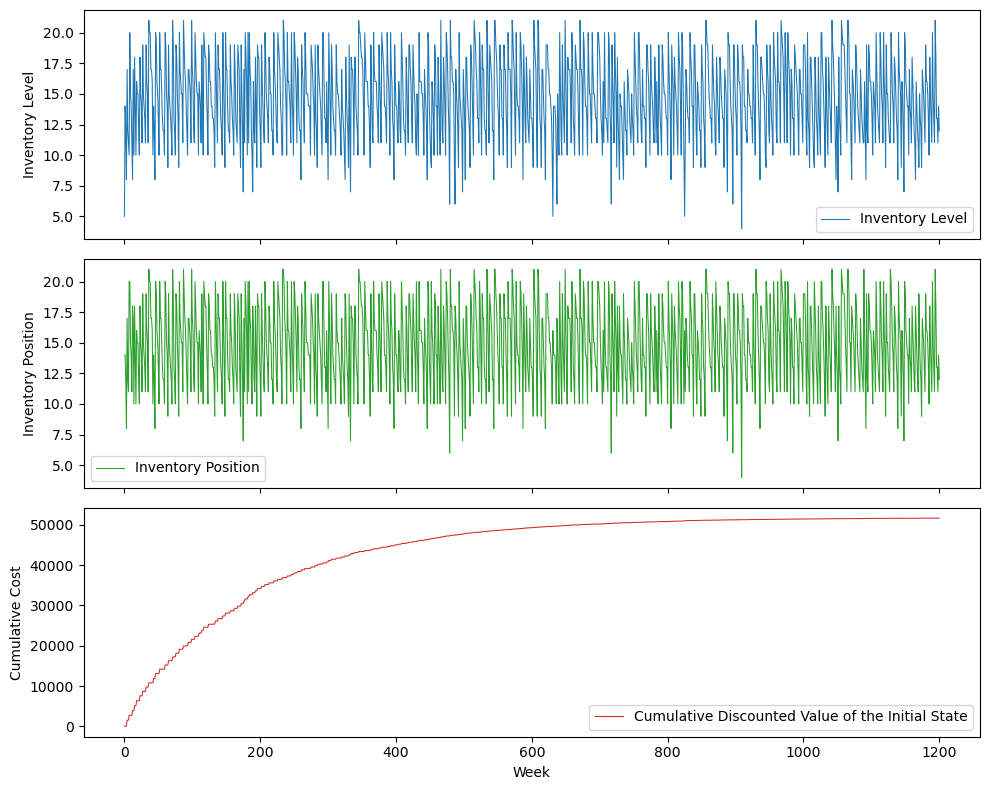

51652.25110840057


In [ ]:
from policy_df_genetor import *

# simulate with the policy given as optimal for flat shortage cost
policy2 = generate_sS_policy(11, 21, maximum_parts)
data2 = simulate_period(sampled_state, policy2)
print(total_cost(data2))

In [20]:
sample_size = 100
sampled_values = np.zeros(len(state_tuples))

for i, state in enumerate(state_tuples):
    value_samples = np.zeros(sample_size)
    for j in range(sample_size):
        sampled_data = simulate_period(state, policy, 1000)
        value_sample = total_cost(sampled_data, plots=False)
        value_samples[j] = value_sample
    sampled_values[i] = np.mean(value_samples)

[  297.76052487  -495.40422789 -1131.10752097   -38.01141131
  -585.79578067  -745.74633194 -1011.32785772   -75.95224912
  -120.96567811  1000.64742042   276.03859739  -484.68861776
  -680.19326129  -285.97434988   608.95292828  -631.46079267
 -1073.78767901  -705.91785209  -479.2860215   -785.41870319
  -643.99424168 -1071.85589462   -22.54978971 -1980.12322765
 -1457.17730452 -1449.68699871   208.00434005 -1118.73733113
   -29.37376931 -1458.37400493  -748.30259607   297.08671234
   330.21087973  -773.9066134   -471.30000045 -1397.74274583
 -1908.43953145  -567.73380562  -641.82008181  -844.31305234
   444.61602929  1391.18540869 -3110.300106     201.22340569
 -1800.9702093    -96.85746121 -1106.27278707 -1261.58609022
  -562.07793428 -1137.3479615   -929.22122526 -1388.56754133
   404.71549437  -676.94633147 -1034.18167139  -389.89248699
  -798.76573123 -1163.24239652  -919.37351975  -785.8872949
   284.12222309 -1097.71826639   285.98890307  -401.537908
 -1089.42191394  -243.07010

Text(0, 0.5, 'Residual')

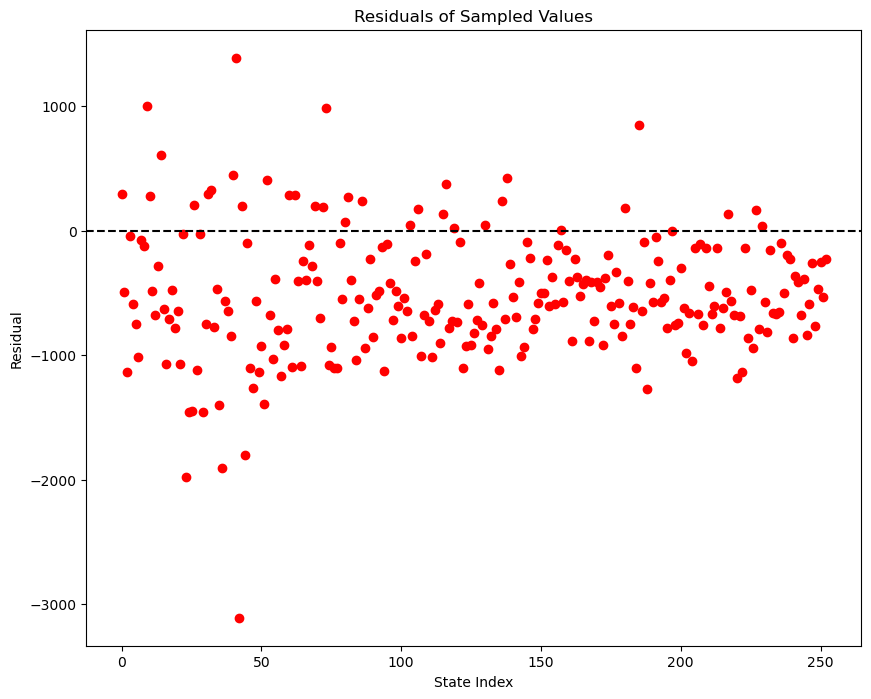

In [23]:
value_iteration_values = np.load("values.npy")
residuals = sampled_values - value_iteration_values
print(residuals)

plt.figure(figsize=(10, 8))
plt.scatter(np.arange(253), residuals, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals of Sampled Values")
plt.xlabel("State Index")
plt.ylabel("Residual")


[ -286.76663901  -572.95345704   388.71032315  -752.20850434
  -286.13863756   400.63797607  -268.12051991 -1464.11199262
  -530.31644032   327.26914974  -706.14025427  -607.46554644
  -803.06785708  -451.30052467  -302.03847124    69.63509278
  -471.29797411  -318.90322117  -266.60286196  -391.58226019
  -355.46173891  -515.75888995  -717.12395552 -1039.67310714
  -227.15112976   -10.45626991     7.23885934   -89.65619921
  -478.09282084 -1108.54355308  -153.40285026  -520.29374148
  -424.96616608   196.46307133  -279.07242745  -725.93957536
   -56.85212179  -236.38577332   755.5731104   -500.40794364
   149.10946489  -510.5720918   -776.55970402 -1748.05898468
    -9.24361437   370.8340133   -221.71286689   238.24480297
  -763.02186131   501.5060744    194.50593385 -1044.92966941
   168.47418273  -558.98785899    89.55112571 -1202.56307277
   237.85057562  -368.17003199  -280.70609963 -1399.5478575
  -336.51220927  -650.08237718  -163.67892942    63.05306362
 -1174.47268057  -263.311

Text(0, 0.5, 'Residual')

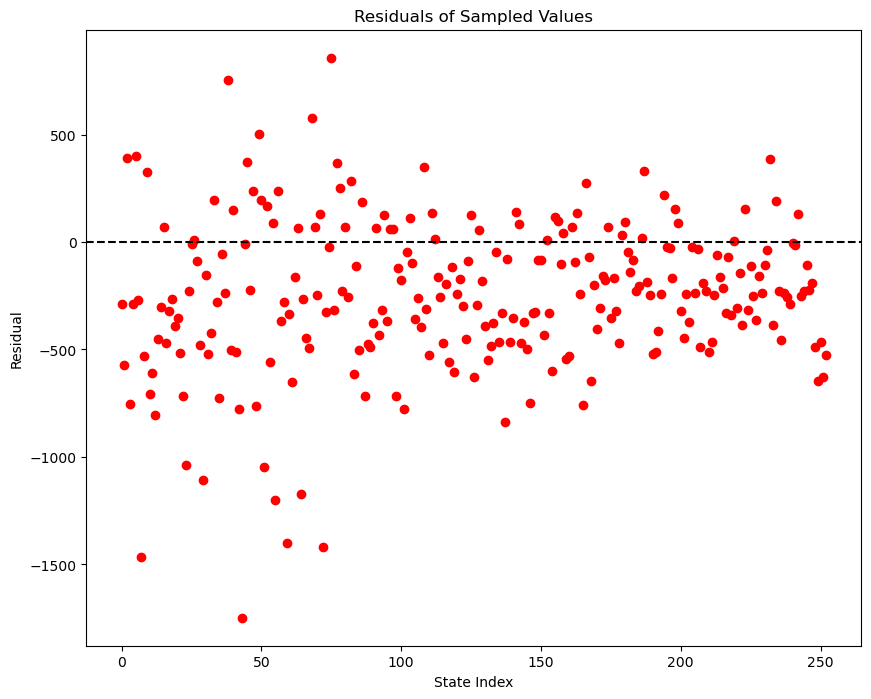

In [24]:
sample_size = 200
sampled_values = np.zeros(len(state_tuples))

for i, state in enumerate(state_tuples):
    value_samples = np.zeros(sample_size)
    for j in range(sample_size):
        sampled_data = simulate_period(state, policy, 4000)
        value_sample = total_cost(sampled_data, plots=False)
        value_samples[j] = value_sample
    sampled_values[i] = np.mean(value_samples)

value_iteration_values = np.load("values.npy")
residuals = sampled_values - value_iteration_values
print(residuals)

plt.figure(figsize=(10, 8))
plt.scatter(np.arange(253), residuals, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals of Sampled Values")
plt.xlabel("State Index")
plt.ylabel("Residual")